# Task 1

## Task 1.1

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.manifold import Isomap
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer

In [2]:
data = pd.read_csv('train_data.csv', index_col=0).reset_index().rename(columns={'index': 'id'})
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 400 non-null    int64  
 1   Age                400 non-null    float64
 2   Gender             400 non-null    int64  
 3   Stage              400 non-null    int64  
 4   GeneticRisk        315 non-null    float64
 5   TreatmentType      400 non-null    int64  
 6   ComorbidityIndex   355 non-null    float64
 7   TreatmentResponse  371 non-null    float64
 8   SurvivalTime       240 non-null    float64
 9   Censored           400 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 31.4 KB


,id,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,0,65.0,0,2,1.0,0,0.0,0.0,4.2,0
1,1,68.0,1,2,0.0,1,1.0,1.0,4.7,1
2,2,68.0,1,3,1.0,1,0.0,1.0,3.5,1
3,3,81.0,1,4,1.0,1,3.0,0.0,2.3,0
4,4,59.0,1,2,1.0,0,NaN,0.0,NaN,0


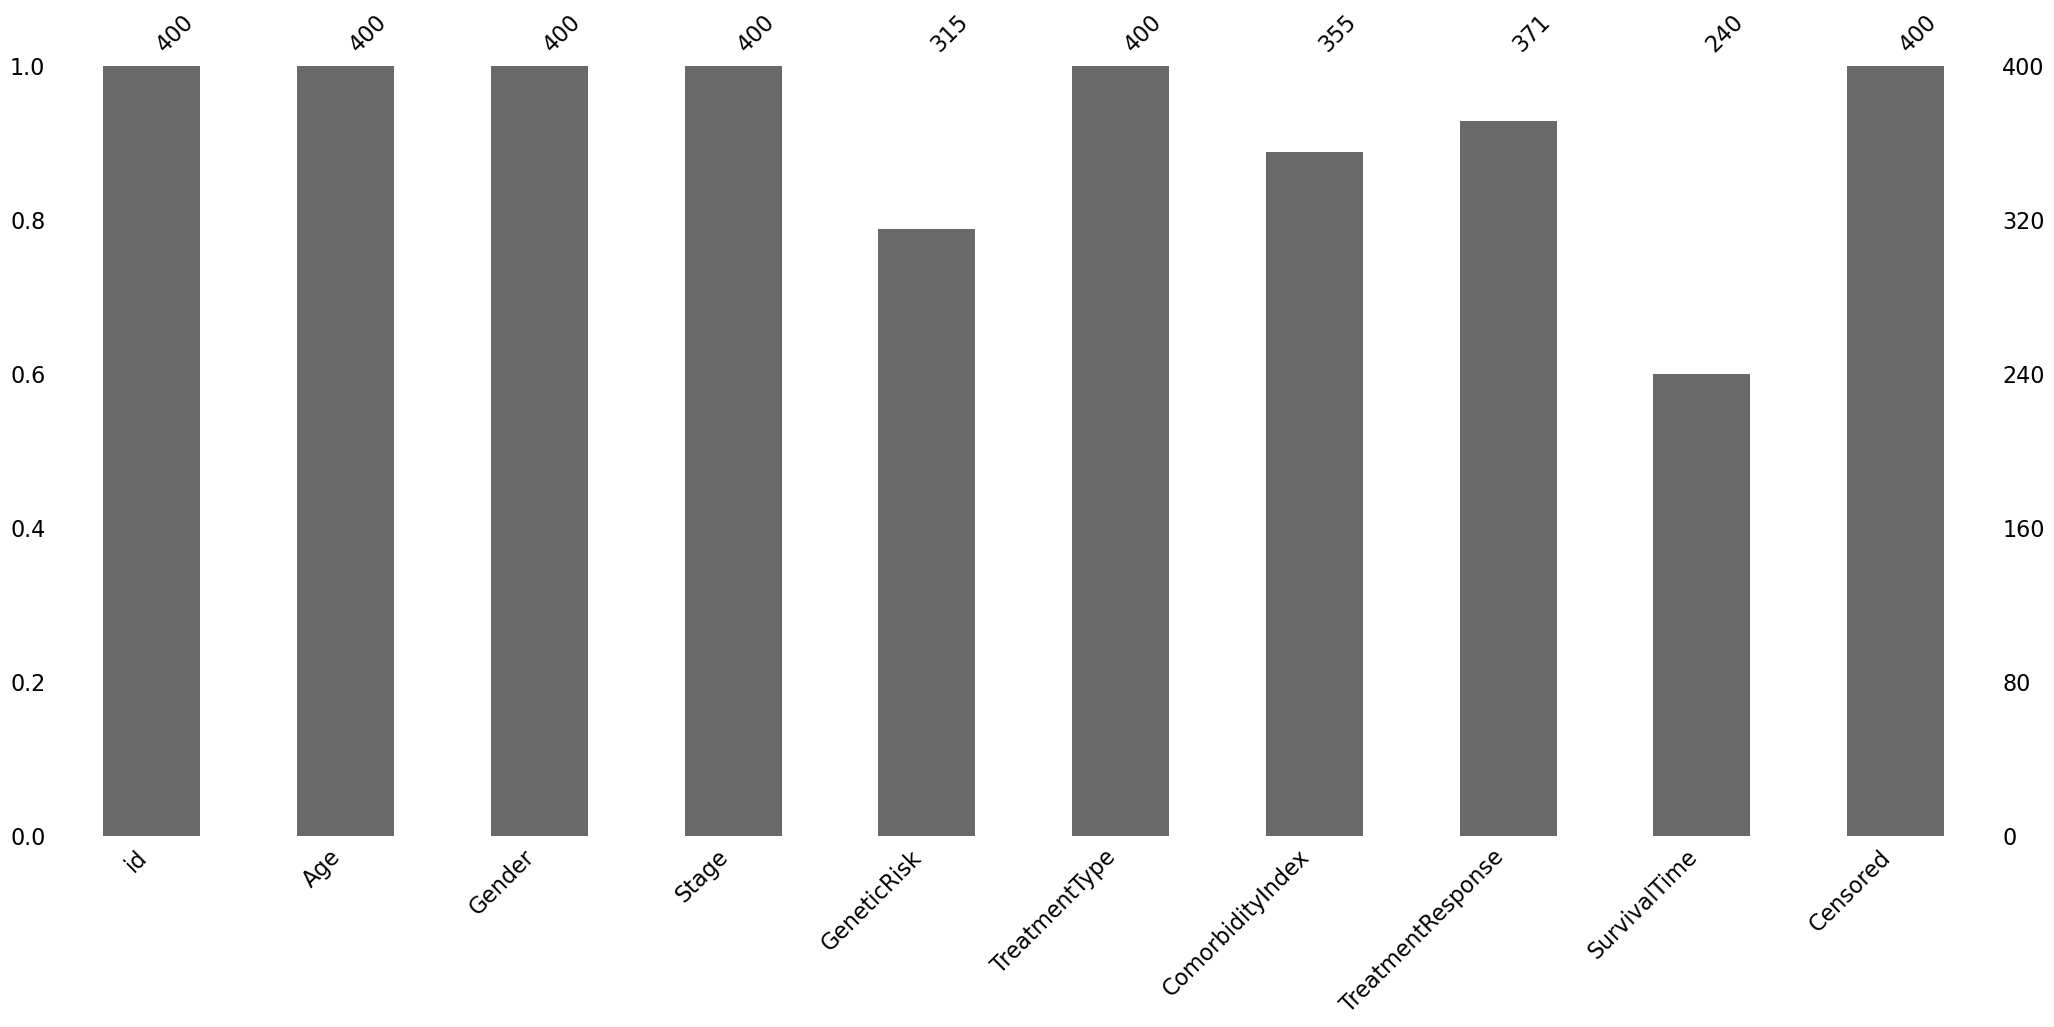

<Figure size 800x600 with 0 Axes>

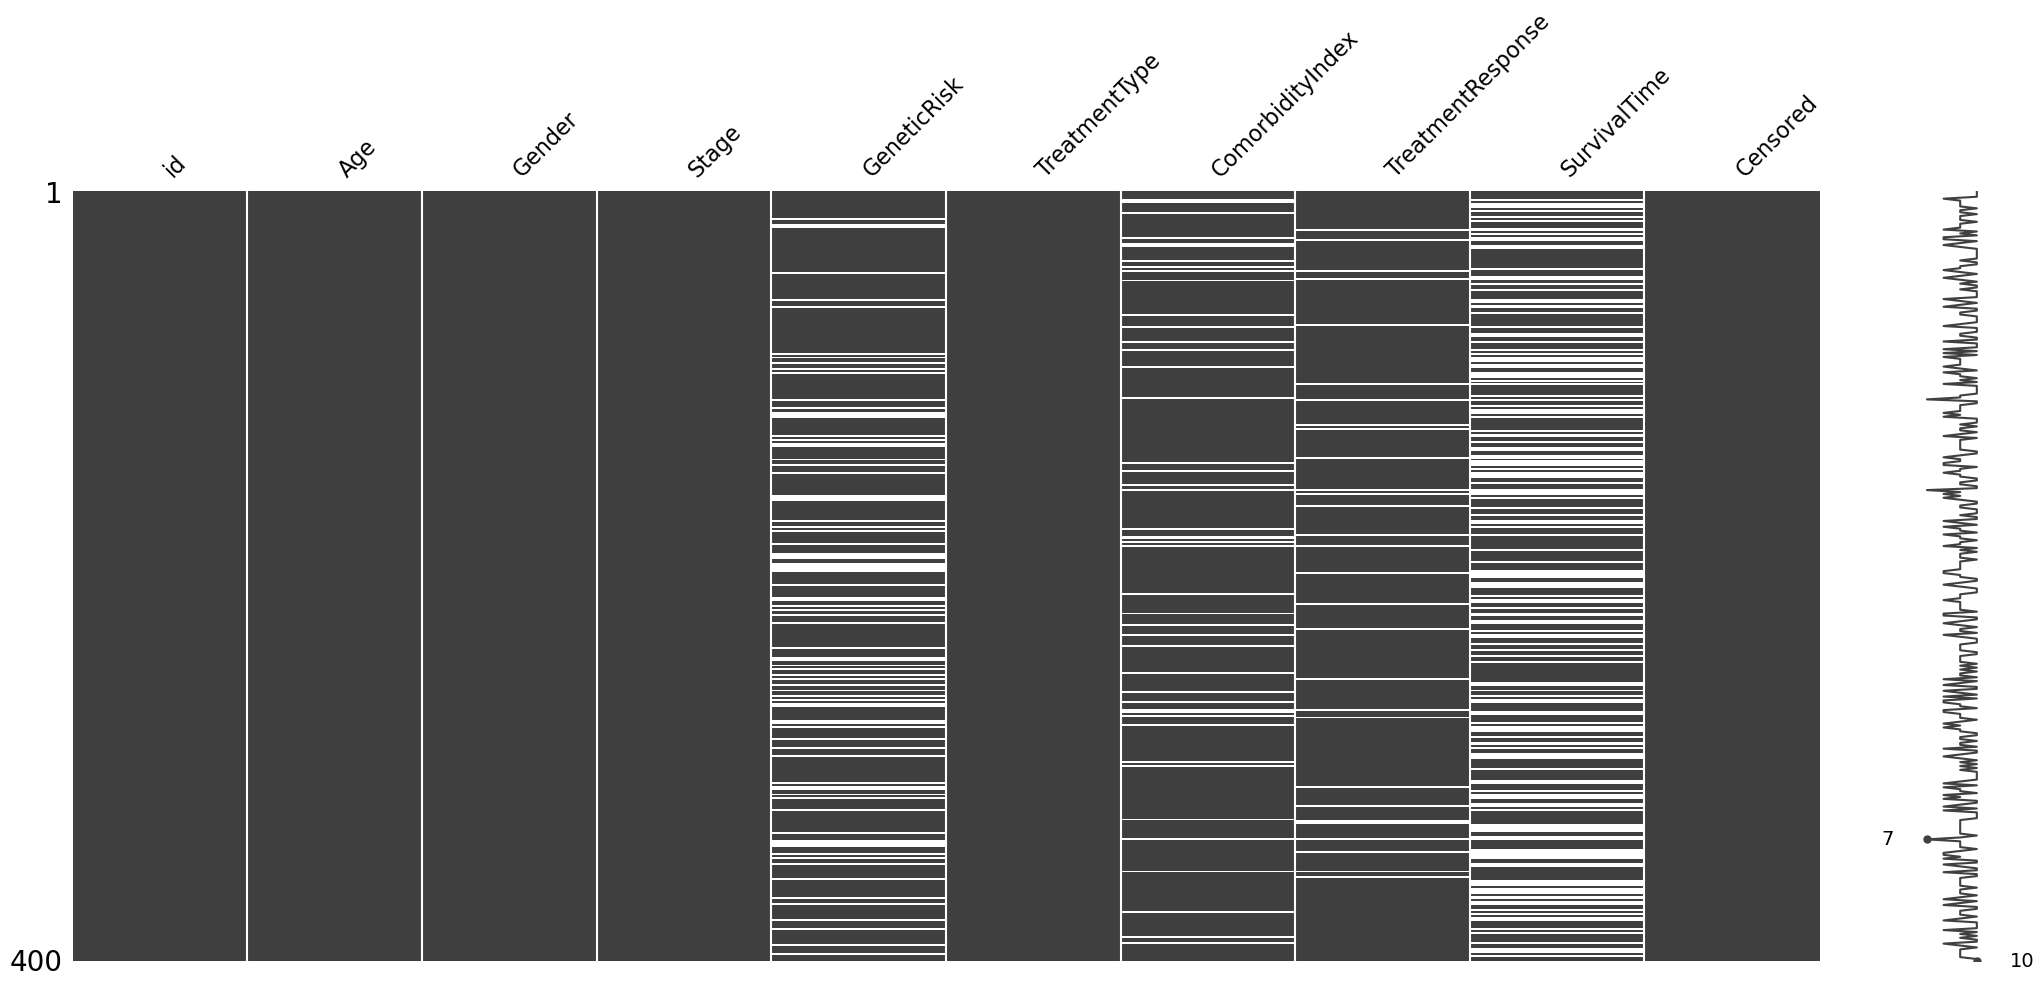

<Figure size 800x600 with 0 Axes>

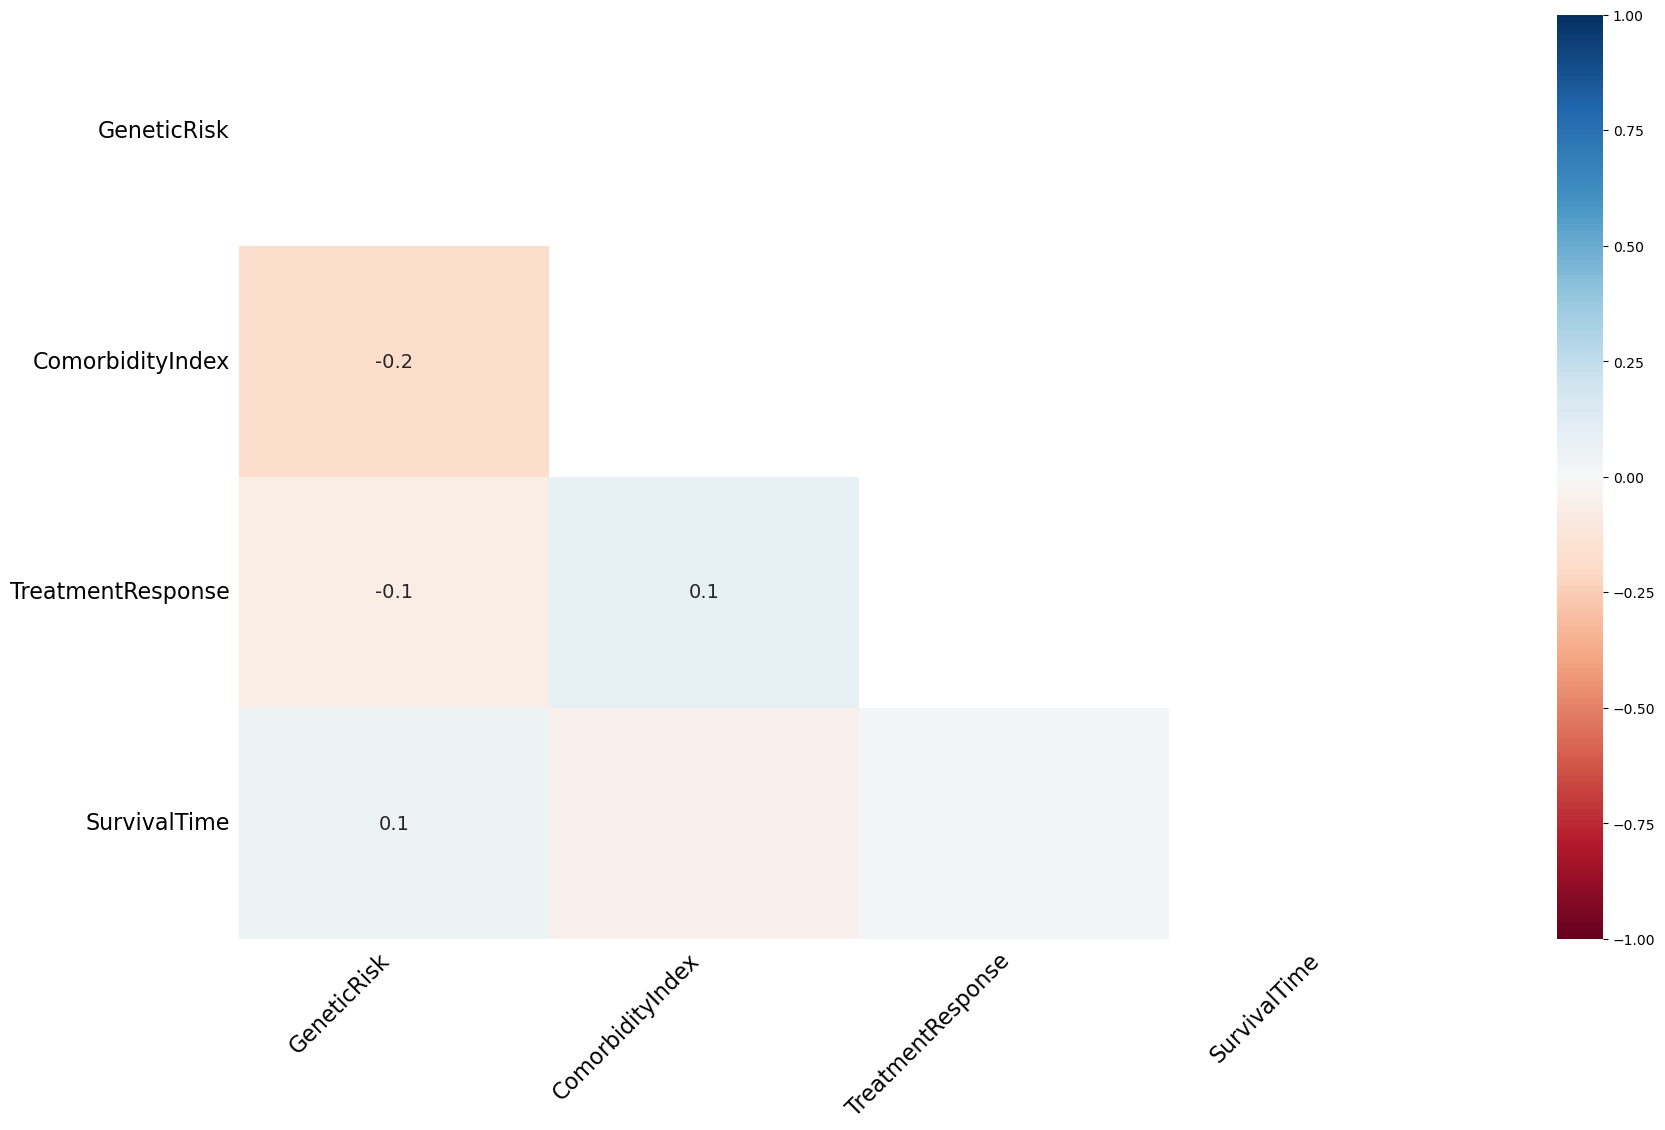

<Figure size 800x600 with 0 Axes>

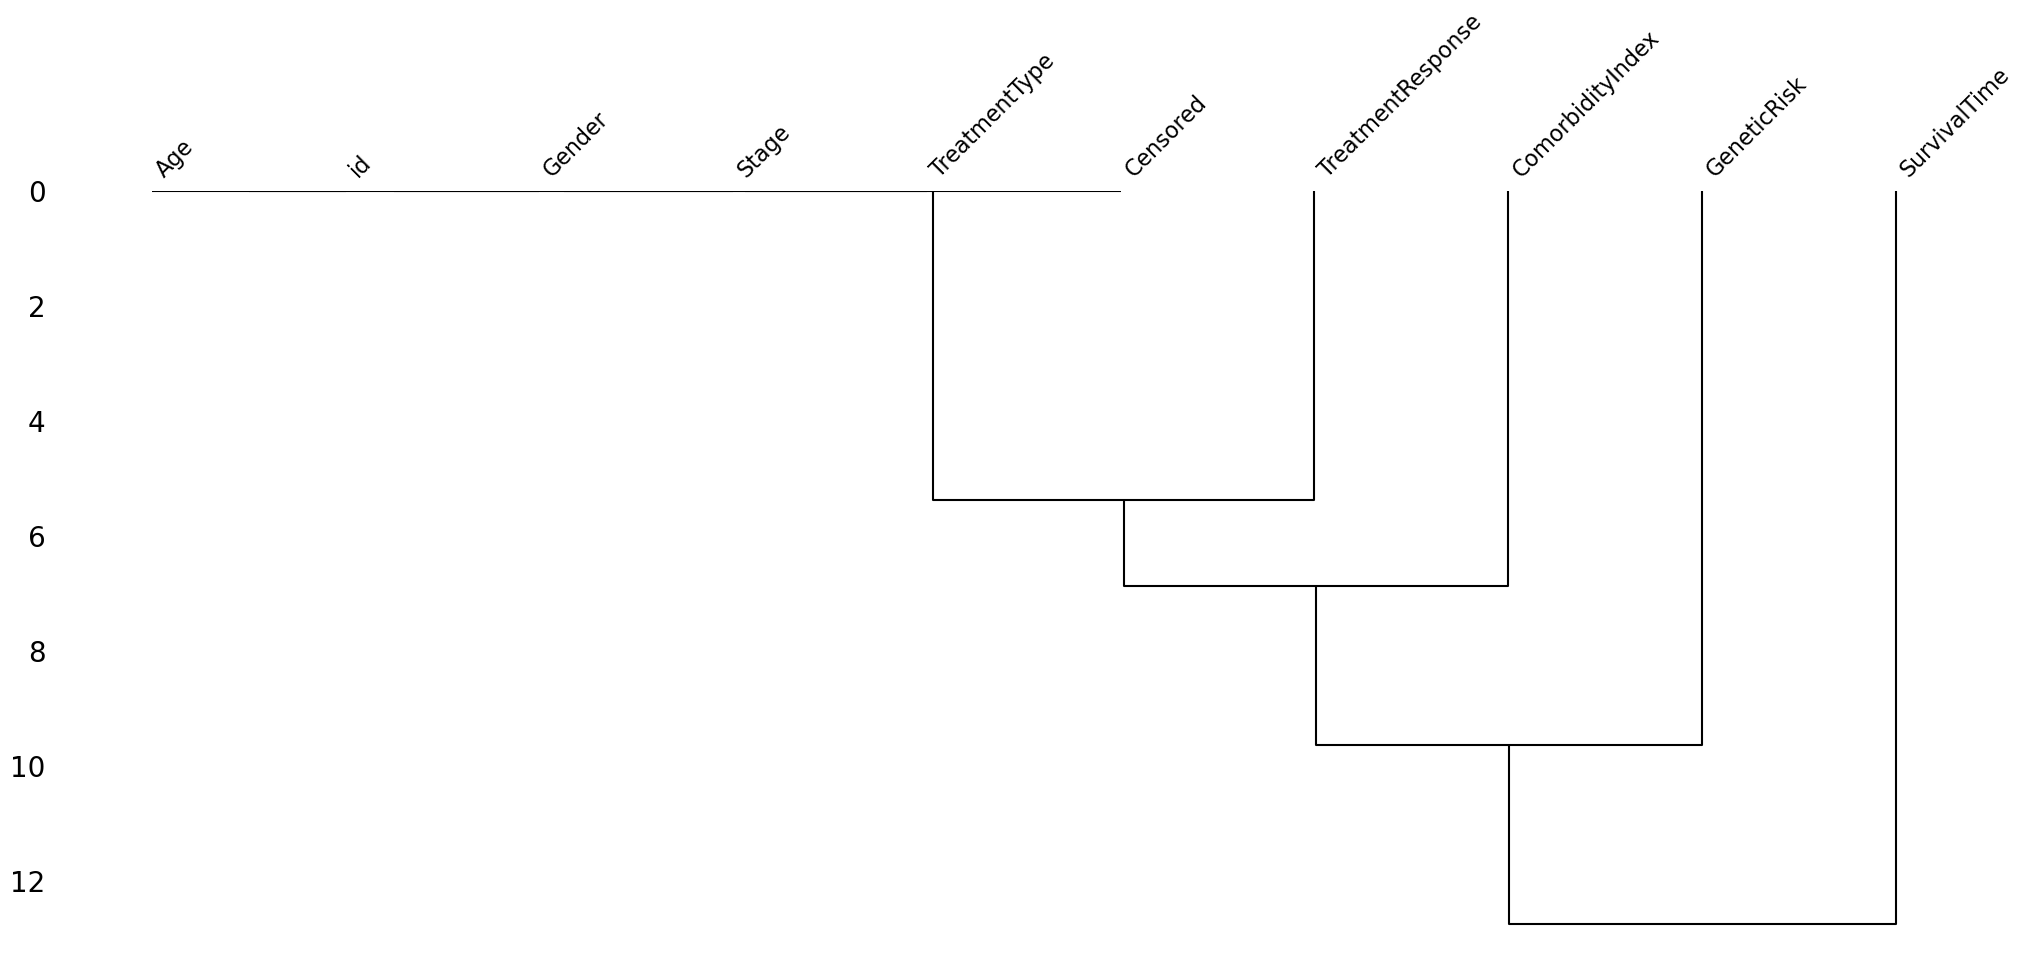

In [3]:
plt.figure(figsize=(8,4)); msno.bar(data); plt.show()
plt.figure(figsize=(8,6)); msno.matrix(data); plt.show()
plt.figure(figsize=(8,6)); msno.heatmap(data); plt.show()
plt.figure(figsize=(8,6)); msno.dendrogram(data); plt.show()

In [4]:
n_total = data.shape[0]
n_missing_surv = data['SurvivalTime'].isna().sum()
n_censored = data['Censored'].sum()  # 1 means censored in dataset
n_death_observed = ((data['Censored']==0) & data['SurvivalTime'].notna()).sum()
print(f"total={n_total}, missing_surv={n_missing_surv}, censored={n_censored}, observed_deaths={n_death_observed}")

total=400, missing_surv=160, censored=79, observed_deaths=161


#### Dataset summary

- Counts: total = 400; SurvivalTime non‑null = 240; censored = 79; observed deaths (uncensored with SurvivalTime) = 161.  
- Feature missingness: GeneticRisk (85 missing), ComorbidityIndex (45 missing), TreatmentResponse (29 missing). Dropping any row with a missing feature will reduce the 161 uncensored cases further; the complete‑case set is therefore likely much smaller than 161.

#### Observed correlations from missingno.heatmap:
- SurvivalTime — GeneticRisk: weak positive (≈ +0.1).  
- GeneticRisk — TreatmentResponse: weak negative (≈ −0.1).  
- GeneticRisk — ComorbidityIndex: weak negative (≈ −0.2).  
- ComorbidityIndex — TreatmentResponse: weak positive (≈ +0.1).  
- SurvivalTime — ComorbidityIndex / TreatmentResponse: essentially no correlation.

#### Practical interpretation
- The observed missingness correlations between GeneticRisk, ComorbidityIndex, TreatmentResponse and SurvivalTime are very small (≈ ±0.1–0.2). These numbers indicate negligible co‑occurrence of missingness — there are no large, clean blocks of rows we can remove without losing diverse information.
- Removing all rows with any missing feature (GeneticRisk: 85 missing; ComorbidityIndex: 45 missing; TreatmentResponse: 29 missing) together with censored rows (79) will therefore mainly reduce sample size rather than eliminate redundant problematic cases. This substantial loss of labeled data will hurt model fitting (higher variance, greater overfitting risk, and unstable validation).

In [5]:
features = ['Age','Gender','Stage','GeneticRisk','TreatmentType','ComorbidityIndex','TreatmentResponse']
missing_feat_cols = [col for col in features if data[col].isna().any()]
print("Feature columns with missing values:", missing_feat_cols)

data_dropcols = data.drop(columns=missing_feat_cols)
print("Columns after dropping features with missing values:", data_dropcols.columns.tolist())

filtered = data_dropcols.dropna(subset=['SurvivalTime']).copy()
filtered_uncensored = filtered[filtered['Censored'] == 0].copy()


display(filtered_uncensored.head())

Feature columns with missing values: ['GeneticRisk', 'ComorbidityIndex', 'TreatmentResponse']
Columns after dropping features with missing values: ['id', 'Age', 'Gender', 'Stage', 'TreatmentType', 'SurvivalTime', 'Censored']


,id,Age,Gender,Stage,TreatmentType,SurvivalTime,Censored
0,0,65.0,0,2,0,4.2,0
3,3,81.0,1,4,1,2.3,0
5,5,47.0,1,4,1,2.6,0
9,9,68.0,1,1,0,6.4,0
11,11,56.0,0,2,0,4.1,0


Remaining feature columns: ['Age', 'Gender', 'Stage', 'TreatmentType']


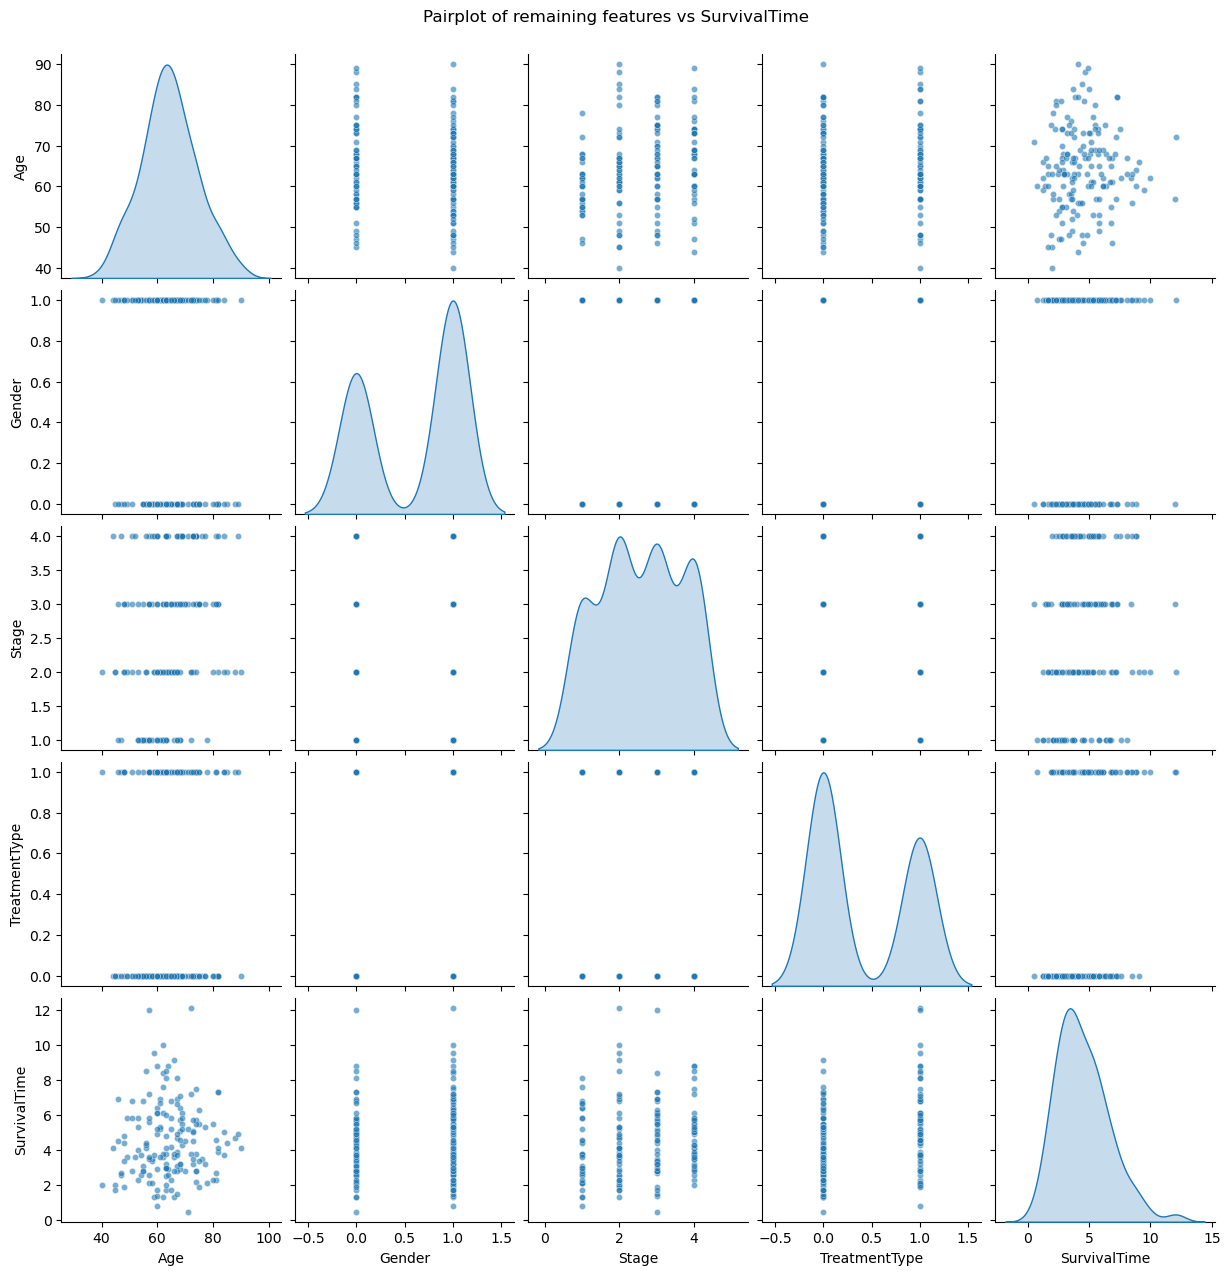

X shape: (161, 4)
y shape: (161,)


,Age,Gender,Stage,TreatmentType
0,65.0,0,2,0
3,81.0,1,4,1
5,47.0,1,4,1
9,68.0,1,1,0
11,56.0,0,2,0


In [6]:
feature_cols = [c for c in data_dropcols.columns if c not in ('id','SurvivalTime','Censored')]
print("Remaining feature columns:", feature_cols)

sns.pairplot(filtered_uncensored[feature_cols + ['SurvivalTime']], diag_kind='kde', plot_kws={'alpha':0.6, 's':20})
plt.suptitle('Pairplot of remaining features vs SurvivalTime', y=1.02)
plt.show()


X_df = filtered_uncensored[feature_cols].copy()
y = filtered_uncensored['SurvivalTime'].values
X = X_df.values

print("X shape:", X.shape)
print("y shape:", y.shape)
display(X_df.head())

#### Which validation procedure is more data‑efficient?
- Cross‑validation. With only 161 complete, uncensored rows (X shape = (161, 4)), a single train/validation/test split will reduce the amount of data available for training and produce high‑variance validation results. Example: a 70/15/15 split leaves ~113 training rows, ~24 validation rows — unstable for model selection.
- K‑fold CV reuses all labeled examples for both training and validation across folds, giving more stable, lower‑variance estimates of generalization and making maximal use of scarce labeled data. 

In [7]:
def error_metric(y, y_hat, c):
    err = y-y_hat
    err = (1-c)*err**2 + c*np.maximum(0,err)**2
    return np.sum(err)/err.shape[0]

## Task 1.2

CV cMSE (out of sample estimate of generalization error): 4.34360364716612
In-sample cMSE (training error): 4.08730729051099


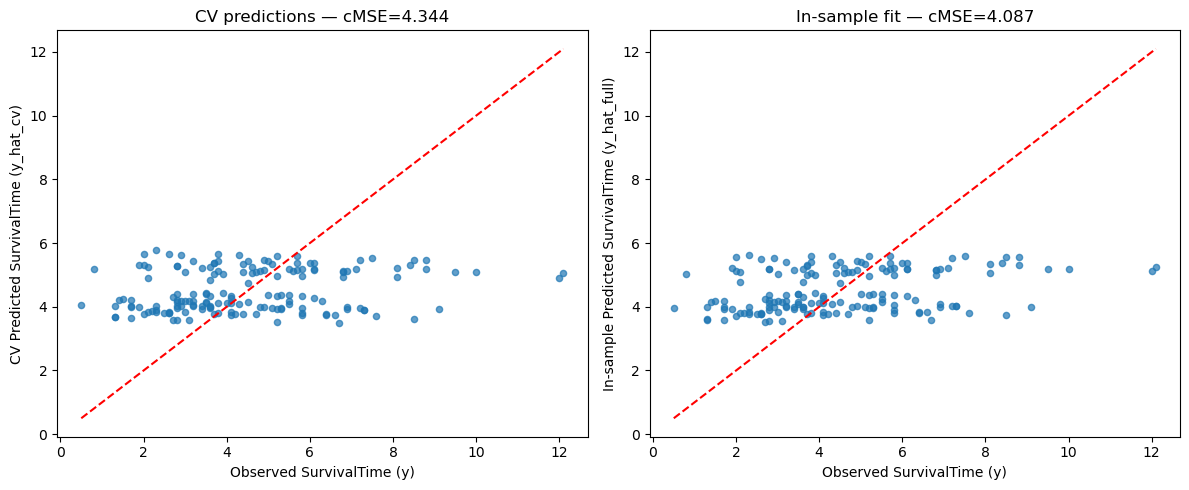

In [8]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

n_points = filtered_uncensored.shape[0]

cv = KFold(n_splits=n_points, shuffle=True, random_state=0)

y_pred_cv = cross_val_predict(pipeline, X, y, cv=cv)

c = filtered_uncensored['Censored'].values

# compute cMSE (equivalent to MSE here because c==0)
cmse_cv = error_metric(y, y_pred_cv, c)
print("CV cMSE (out of sample estimate of generalization error):", cmse_cv)

pipeline.fit(X, y)
y_pred_full = pipeline.predict(X)
cmse_full = error_metric(y, y_pred_full, c)
print("In-sample cMSE (training error):", cmse_full)

# y vs y_hat plots
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y, y_pred_cv, alpha=0.7, s=20)
maxv = max(y.max(), y_pred_cv.max())
minv = min(y.min(), y_pred_cv.min())
plt.plot([minv, maxv], [minv, maxv], 'r--')
plt.xlabel('Observed SurvivalTime (y)')
plt.ylabel('CV Predicted SurvivalTime (y_hat_cv)')
plt.title(f'CV predictions — cMSE={cmse_cv:.3f}')

plt.subplot(1,2,2)
plt.scatter(y, y_pred_full, alpha=0.7, s=20)
maxv = max(y.max(), y_pred_full.max())
minv = min(y.min(), y_pred_full.min())
plt.plot([minv, maxv], [minv, maxv], 'r--')
plt.xlabel('Observed SurvivalTime (y)')
plt.ylabel('In-sample Predicted SurvivalTime (y_hat_full)')
plt.title(f'In-sample fit — cMSE={cmse_full:.3f}')

plt.tight_layout()
plt.show()



In [9]:
test = pd.read_csv('test_data.csv')

cols_to_drop = [c for c in missing_feat_cols if c in test.columns]
test_drop = test.drop(columns=cols_to_drop)

X_test = test_drop[feature_cols].values

y_test_pred = pipeline.predict(X_test)

submission = pd.DataFrame({
    'id': test_drop['id'].values,
    '0': y_test_pred
})


submission.to_csv('baseline-submission-01.csv', index=False)
print("Saved baseline-submission-01.csv:")
display(submission.head())

Saved baseline-submission-01.csv:


,id,0
0,0,5.588019
1,1,4.321626
2,2,3.782002
3,3,5.194959
4,4,4.305387


# Task 2. Nonlinear Models

## Task 2.1 Development

In [10]:
def select_polynomial_degree(X, y, c, cv, degrees=range(1,10), regressor=None, verbose=True):
    print("--- Tuning Polynomial Regression (Degree) ---")
    degrees = list(degrees)
    results = {}
    if regressor is None:
        regressor = LinearRegression()
    for d in degrees:
        pipe = Pipeline([
            ('poly', PolynomialFeatures(degree=d, include_bias=False)),
            ('scaler', StandardScaler()),
            ('reg', regressor)   # (Ridge or LR)
        ])
        y_pred_cv = cross_val_predict(pipe, X, y, cv=cv)
        cmse = error_metric(y, y_pred_cv, c)
        results[d] = cmse
        if verbose:
            print(f"degree={d}: CV cMSE={cmse:.6f}")
    best = min(results, key=results.get)
    if verbose:
        print(f"Selected degree={best} (CV cMSE={results[best]:.6f})\n")
    return best, results


In [11]:
def select_k_knn(X, y, c, cv, ks=range(1,16), verbose=True):
    print("--- Tuning k-Nearest Neighbors (k) ---")
    ks = list(ks)  
    results = {}
    for k in ks:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_neighbors=k))
        ])
        y_pred_cv = cross_val_predict(pipe, X, y, cv=cv)
        cmse = error_metric(y, y_pred_cv, c)
        results[k] = cmse
        if verbose:
            print(f"k={k}: CV cMSE={cmse:.6f}")
    best = min(results, key=results.get)
    if verbose:
        print(f"Selected k={best} (CV cMSE={results[best]:.6f})\n")
    return best, results

In [12]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('reg', Ridge(random_state=0))
])

param_grid = {
    'poly__degree': list(range(1,7)),
    'reg__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

cv = KFold(n_splits=5, shuffle=True, random_state=0)
gs = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
gs.fit(X, y)

print("best params:", gs.best_params_)
best_degree = gs.best_params_['poly__degree']
best_alpha  = gs.best_params_['reg__alpha']
print(f"best_degree={best_degree}, best_alpha={best_alpha}, best CV MSE={-gs.best_score_:.6f}")

best params: {'poly__degree': 1, 'reg__alpha': 10.0}
best_degree=1, best_alpha=10.0, best CV MSE=4.341482


In [13]:
ks_to_test = range(1, 21)
best_k, knn_results = select_k_knn(X, y, c, cv, ks=ks_to_test)

--- Tuning k-Nearest Neighbors (k) ---
k=1: CV cMSE=7.519068
k=2: CV cMSE=5.795435
k=3: CV cMSE=5.188399
k=4: CV cMSE=4.898544
k=5: CV cMSE=4.819327
k=6: CV cMSE=4.690072
k=7: CV cMSE=4.711721
k=8: CV cMSE=4.596708
k=9: CV cMSE=4.576559
k=10: CV cMSE=4.552331
k=11: CV cMSE=4.477968
k=12: CV cMSE=4.454981
k=13: CV cMSE=4.476726
k=14: CV cMSE=4.467936
k=15: CV cMSE=4.465945
k=16: CV cMSE=4.373552
k=17: CV cMSE=4.416770
k=18: CV cMSE=4.389705
k=19: CV cMSE=4.420290
k=20: CV cMSE=4.356436
Selected k=20 (CV cMSE=4.356436)



## Task 2.2

In [14]:

print("--- Model Evaluation ---")

# 1. Baseline Model (from Task 1.2)
pipe_lr = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
y_pred_lr = cross_val_predict(pipe_lr, X, y, cv=cv)
cmse_lr = error_metric(y, y_pred_lr, c) # This was 4.3436 in Task 1.2
err_lr = y - y_pred_lr

# 2. Best Polynomial Model (using best_degree and best_alpha from ridge found)
pipe_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', StandardScaler()),
    ('reg', Ridge(alpha=best_alpha))
])
y_pred_poly = cross_val_predict(pipe_poly, X, y, cv=cv)
cmse_poly = error_metric(y, y_pred_poly, c)
err_poly = y - y_pred_poly

# 3. Best k-NN Model (using best_k found)
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=best_k))
])
y_pred_knn = cross_val_predict(pipe_knn, X, y, cv=cv)
cmse_knn = error_metric(y, y_pred_knn, c)
err_knn = y - y_pred_knn

# Create comparison table data
eval_data = {
    'Model': ['Baseline (LinReg)', f'Polynomial (d={best_degree})', f'k-NN (k={best_k})'],
    'CV cMSE (Mean Error)': [cmse_lr, cmse_poly, cmse_knn],
    'Error Max': [np.max(err_lr), np.max(err_poly), np.max(err_knn)],
    'Error Min': [np.min(err_lr), np.min(err_poly), np.min(err_knn)],
    'Error Std Dev': [np.std(err_lr), np.std(err_poly), np.std(err_knn)]
}
eval_df = pd.DataFrame(eval_data)
print(eval_df.to_markdown(index=False, floatfmt='.4f'))
print("\n")


--- Model Evaluation ---
| Model             |   CV cMSE (Mean Error) |   Error Max |   Error Min |   Error Std Dev |
|:------------------|-----------------------:|------------:|------------:|----------------:|
| Baseline (LinReg) |                 4.3546 |      7.1280 |     -4.4324 |          2.0867 |
| Polynomial (d=1)  |                 4.3414 |      7.1596 |     -4.3690 |          2.0836 |
| k-NN (k=20)       |                 4.3564 |      6.7750 |     -5.4800 |          2.0867 |




In [15]:
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=best_k))
])
knn_pipe.fit(X, y)

test = pd.read_csv('test_data.csv')
cols_to_drop = [col for col in missing_feat_cols if col in test.columns]
test_drop = test.drop(columns=cols_to_drop)
X_test = test_drop[feature_cols].values

y_test_pred = knn_pipe.predict(X_test)

submission_knn = pd.DataFrame({
    'id': test_drop['id'].values,
    '0': y_test_pred
})
submission_knn.to_csv('knn-submission-03.csv', index=False)
print("Saved knn-submission-03.csv")



Saved knn-submission-03.csv


In [16]:
pipe_poly_best = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', StandardScaler()),
    ('reg', Ridge(alpha=best_alpha, random_state=0))
])

pipe_poly_best.fit(X, y)

test = pd.read_csv('test_data.csv')
cols_to_drop = [col for col in missing_feat_cols if col in test.columns]
test_drop = test.drop(columns=cols_to_drop)
X_test = test_drop[feature_cols].values

y_test_pred = pipe_poly_best.predict(X_test)

submission_nonlinear = pd.DataFrame({
    'id': test_drop['id'].values,
    '0': y_test_pred
})
submission_nonlinear.to_csv('Nonlinear-submission-00.csv', index=False)
print("Saved Nonlinear-submission-00.csv")

Saved Nonlinear-submission-00.csv


## Short summary about results:

- The primary reason simple models win is dataset size: after dropping missing features and censored rows our training set is only 161 rows.
- With N = 161, high‑capacity models (e.g. 5th‑degree polynomials, k=1 k‑NN) overfit easily — they learn noise, not signal.
- A simple linear model has much lower variance and is therefore more robust; cross‑validation and the leaderboard confirm this.

- It is normal for the baseline to beat complex models, since on small datasets simple models often outperform complex ones (bias–variance trade‑off).

How to improve
- The baseline is hard to beat using only these 4 features. To improve we need more reliable information for the model.
- The key issue: in Task 1.1 we dropped columns with missing values. Instead of dropping them, we should impute missing values (mean/mode, KNN imputation, or model‑based multiple imputation) to retain informative features and potentially improve performance.

# Task 3. Handling missing data

In [17]:
#%pip install catboost

In [18]:
# Helper functions

def censored_mse(y_true, y_pred, censored):
    # y_true, y_pred, censored are numpy arrays same length
    err = y_true - y_pred
    # for censored=1 -> only penalize underestimation: max(0,err)**2
    # for censored=0 -> full squared error
    out = (1 - censored) * (err ** 2) + censored * (np.maximum(0, err) ** 2)
    return out.mean()

# a scorer that accepts (estimator, X, y_complete) where y_complete must include censoring info
# since sklearn's cross_val_score passes only X and y, we'll work around by packing censoring into y

def make_cmse_scorer(censor_array):
    def scorer(estimator, X, y):
        y_pred = estimator.predict(X)
        return -censored_mse(y, y_pred, censor_array)
    return make_scorer(scorer, greater_is_better=True)

try:
    data
except NameError:
    data = pd.read_csv('train_data.csv', index_col=0).reset_index().rename(columns={'index':'id'})
    test = pd.read_csv('test_data.csv')

target_col = 'SurvivalTime'
censor_col = 'Censored'
feature_cols = [c for c in data.columns if c not in ('id', target_col, censor_col)]

# Keep track of missingness
missing_feat_cols = [c for c in feature_cols if data[c].isna().any()]
print(f"Feature columns: {len(feature_cols)}, with missing: {missing_feat_cols}")

# Create a labeled set: records with non-missing SurvivalTime (y) and *use their censoring values too*
labeled = data[~data[target_col].isna()].copy()
print(f"Labeled rows: {len(labeled)} of {len(data)}")

X_labeled = labeled[feature_cols]
y_labeled = labeled[target_col].values
c_labeled = labeled[censor_col].values

# We'll use KFold on the labeled data (uncensored+possibly censored) for data efficiency.
kf = KFold(n_splits=10, shuffle=True, random_state=42)

def cross_val_cmse(estimator, X, y, c, cv):
    scores = []
    for train_idx, val_idx in cv.split(X):
        Xtr, Xv = X.iloc[train_idx], X.iloc[val_idx]
        ytr, yv = y[train_idx], y[val_idx]
        ctr, cv_c = c[train_idx], c[val_idx]
        # fit
        estimator.fit(Xtr, ytr)
        yp = estimator.predict(Xv)
        scores.append(censored_mse(yv, yp, cv_c))
    return np.array(scores)

Feature columns: 7, with missing: ['GeneticRisk', 'ComorbidityIndex', 'TreatmentResponse']
Labeled rows: 240 of 400


## Task 3.1. Missing data imputation

In [19]:

imputers = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'most_frequent': SimpleImputer(strategy='most_frequent'),
    'knn': KNNImputer(n_neighbors=5),
    'iterative': IterativeImputer(random_state=0, max_iter=10)
}

baseline_results = []
for name, imp in imputers.items():
    pipe = Pipeline([
        ('imputer', imp),
        ('scaler', StandardScaler()),
        ('lr', LinearRegression())
    ])
    scores = cross_val_cmse(pipe, X_labeled, y_labeled, c_labeled, kf)
    baseline_results.append((name, scores.mean(), scores.std(), scores.min(), scores.max()))

results_df = pd.DataFrame(baseline_results, columns=['imputer','mean','std','min','max']).sort_values('mean')
print('\nBaseline (Linear Regression) with various imputers:')
print(results_df)

# obtain the best imputer from Task 3.1
best_imputer_name = results_df.iloc[0]['imputer']
best_imputer = imputers[best_imputer_name]

# baseline model = LR + best imputer + scaler
baseline_pipe = Pipeline([
    ('imputer', copy.deepcopy(best_imputer)),
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

baseline_scores = cross_val_cmse(baseline_pipe, X_labeled, y_labeled, c_labeled, kf)

print("\nBaseline_scores (Task 3.1 best imputation + Linear Regression):")
print("mean:", baseline_scores.mean())
print("std:", baseline_scores.std())
print("min:", baseline_scores.min())
print("max:", baseline_scores.max())



Baseline (Linear Regression) with various imputers:
         imputer      mean       std       min       max
0           mean  2.562758  0.647658  1.791867  3.920905
4      iterative  2.566978  0.643732  1.816882  3.909431
3            knn  2.579375  0.650383  1.805227  3.987060
1         median  2.604280  0.735549  1.711563  4.167667
2  most_frequent  2.604280  0.735549  1.711563  4.167667

Baseline_scores (Task 3.1 best imputation + Linear Regression):
mean: 2.562757786610505
std: 0.6476583991554739
min: 1.791866958080768
max: 3.920904880504692



--- Comparison of Task 3.1 Baseline vs. Task 1.2 Baseline ---
| Model                                         |   CV cMSE |
|:----------------------------------------------|----------:|
| Task 1.2 Baseline (No Imputation, 161 rows)   |    4.3436 |
| Task 3.1 Baseline (Mean Imputation, 240 rows) |    2.5628 |

Generating y-y_hat plot for the best Task 3.1 model...


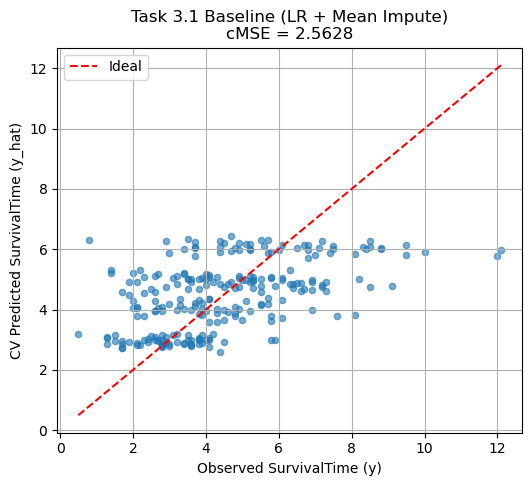


--- Applying Best Imputer to Task 2 Models ---
| Model                                      |   CV cMSE |
|:-------------------------------------------|----------:|
| Polynomial (d=1, alpha=10.0) + Mean Impute |    2.5670 |
| k-NN (k=20) + Mean Impute                  |    2.7620 |


In [20]:
print("\n--- Comparison of Task 3.1 Baseline vs. Task 1.2 Baseline ---")
# The cmse_cv from Task 1.2 was 4.3436
task1_2_cmse = cmse_cv 
task3_1_cmse = baseline_scores.mean()

comparison_df = pd.DataFrame({
    'Model': ['Task 1.2 Baseline (No Imputation, 161 rows)', 'Task 3.1 Baseline (Mean Imputation, 240 rows)'],
    'CV cMSE': [task1_2_cmse, task3_1_cmse]
})
print(comparison_df.to_markdown(index=False, floatfmt='.4f'))

# Generating y-y_hat plot for the new baseline model
print("\nGenerating y-y_hat plot for the best Task 3.1 model...")
y_pred_baseline_imputed = cross_val_predict(baseline_pipe, X_labeled, y_labeled, cv=kf)

plt.figure(figsize=(6, 5))
plt.scatter(y_labeled, y_pred_baseline_imputed, alpha=0.6, s=20)
max_val = max(y_labeled.max(), y_pred_baseline_imputed.max())
min_val = min(y_labeled.min(), y_pred_baseline_imputed.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
plt.xlabel('Observed SurvivalTime (y)')
plt.ylabel('CV Predicted SurvivalTime (y_hat)')
plt.title(f'Task 3.1 Baseline (LR + Mean Impute)\ncMSE = {task3_1_cmse:.4f}')
plt.legend()
plt.grid(True)
plt.show()


# Applying best imputer to best models from Task 2
print("\n--- Applying Best Imputer to Task 2 Models ---")

best_imputer_from_3_1 = copy.deepcopy(best_imputer)

# Polynomial Ridge model from Task 2 with imputation
pipe_poly_imputed = Pipeline([
    ('imputer', best_imputer_from_3_1),
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', StandardScaler()),
    ('reg', Ridge(alpha=best_alpha, random_state=0))
])
poly_imputed_scores = cross_val_cmse(pipe_poly_imputed, X_labeled, y_labeled, c_labeled, kf)

# k-NN model from Task 2 with imputation
pipe_knn_imputed = Pipeline([
    ('imputer', copy.deepcopy(best_imputer)), # Use another copy
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=best_k))
])
knn_imputed_scores = cross_val_cmse(pipe_knn_imputed, X_labeled, y_labeled, c_labeled, kf)

# results
task2_imputed_results = pd.DataFrame({
    'Model': [
        f'Polynomial (d={best_degree}, alpha={best_alpha}) + Mean Impute',
        f'k-NN (k={best_k}) + Mean Impute'
    ],
    'CV cMSE': [
        poly_imputed_scores.mean(),
        knn_imputed_scores.mean()
    ]
})
print(task2_imputed_results.to_markdown(index=False, floatfmt='.4f'))

## Task 3.2 - Train models that do not require imputation

In [21]:
# 1. Define Standard Models (HGB & RF) that use the numeric X_labeled
# -------------------------------------------------------------------
models_numeric = {
    'HGB': HistGradientBoostingRegressor(random_state=0, max_iter=200),
    'RandomForest_mean': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), 
        ('rf', RandomForestRegressor(n_estimators=200, random_state=0))
    ])
}

model_results = []
print("--- Evaluating Standard Models (Numeric) ---")
for name, model in models_numeric.items():
    # Use the original numeric X_labeled here
    scores = cross_val_cmse(model, X_labeled, y_labeled, c_labeled, kf)
    model_results.append((name, scores.mean(), scores.std(), scores.min(), scores.max()))
    print(f"Model: {name}, cMSE: {scores.mean():.4f}")


# Prepare Data Specifically for CatBoost (String Categories)
X_catboost = X_labeled.copy()

# List of categorical columns
cat_cols_names = ['Gender', 'Stage', 'TreatmentType', 'TreatmentResponse']

# Convert these columns to strings. This turns NaN into "nan", which CatBoost handles automatically.
for col in cat_cols_names:
    X_catboost[col] = X_catboost[col].astype(str)

# Recalculate indices based on the dataframe columns
cat_features_indices = [X_catboost.columns.get_loc(col) for col in cat_cols_names]

# Define CatBoost Model
cat_model = CatBoostRegressor(
    random_state=0, 
    verbose=0, 
    cat_features=cat_features_indices, 
    iterations=300
)

print("\n--- Evaluating CatBoost (Categorical Handling) ---")
scores_cat = cross_val_cmse(cat_model, X_catboost, y_labeled, c_labeled, kf)
model_results.append(('CatBoost', scores_cat.mean(), scores_cat.std(), scores_cat.min(), scores_cat.max()))
print(f"Model: CatBoost, cMSE: {scores_cat.mean():.4f}")


# 3. CatBoost AFT Model Evaluation
# -------------------------------------------------------------------
print("\n--- Evaluating CatBoost AFT Model ---")

# Prepare survival target
y_lower = y_labeled
y_upper = np.where(c_labeled == 1, -1, y_labeled)
y_aft_labeled = np.stack([y_lower, y_upper], axis=1)

# Define AFT model
cat_aft = CatBoostRegressor(
    loss_function='SurvivalAft:dist=Normal',
    random_state=0, 
    verbose=0, 
    cat_features=cat_features_indices, 
    iterations=300
)

# Custom CV loop for AFT model
aft_scores = []
for train_idx, val_idx in kf.split(X_catboost):
    # Use X_catboost for features
    Xtr, Xv = X_catboost.iloc[train_idx], X_catboost.iloc[val_idx]
    y_aft_tr = y_aft_labeled[train_idx]
    yv = y_labeled[val_idx]
    cv_c = c_labeled[val_idx]

    cat_aft.fit(Xtr, y_aft_tr)
    
    # Predict log-time and exponentiate
    yp_log = cat_aft.predict(Xv)
    yp = np.exp(yp_log)
    aft_scores.append(censored_mse(yv, yp, cv_c))

aft_scores = np.array(aft_scores)
print(f"Model: CatBoost_AFT, cMSE: {aft_scores.mean():.4f}")
model_results.append(('CatBoost_AFT', aft_scores.mean(), aft_scores.std(), aft_scores.min(), aft_scores.max()))


# --- Final Comparison ---
models_df = pd.DataFrame(model_results, columns=['model','mean','std','min','max']).sort_values('mean')
print('\n--- Overall Model Comparison ---')
print(models_df.to_markdown(index=False, floatfmt='.4f'))

# Save scores for next task
hgb_scores = models_df[models_df['model'] == 'HGB']['mean'].values
rf_scores = models_df[models_df['model'] == 'RandomForest_mean']['mean'].values
best_imp = 'mean' # From Task 3.1
best_imp_obj = imputers[best_imp]

--- Evaluating Standard Models (Numeric) ---
Model: HGB, cMSE: 3.2049
Model: RandomForest_mean, cMSE: 3.2744

--- Evaluating CatBoost (Categorical Handling) ---
Model: CatBoost, cMSE: 3.1074

--- Evaluating CatBoost AFT Model ---
Model: CatBoost_AFT, cMSE: 4.3151

--- Overall Model Comparison ---
| model             |   mean |    std |    min |    max |
|:------------------|-------:|-------:|-------:|-------:|
| CatBoost          | 3.1074 | 0.8302 | 1.9240 | 4.6965 |
| HGB               | 3.2049 | 1.0778 | 1.6046 | 4.8424 |
| RandomForest_mean | 3.2744 | 0.8305 | 2.1417 | 4.9160 |
| CatBoost_AFT      | 4.3151 | 1.3476 | 2.4675 | 6.3829 |


## Task 3.3 - Evaluation

--- Final Model Comparison ---
Comparing all models developed across all tasks:
| Model                                          |   CV cMSE |
|:-----------------------------------------------|----------:|
| Task 3.1 Baseline (LR + Mean Impute, 240 rows) |    2.5628 |
| Polynomial (d=1, alpha=10.0) + Mean Impute     |    2.5670 |
| k-NN (k=20) + Mean Impute                      |    2.7620 |
| CatBoost (Native Missing Support)              |    3.1074 |
| HGB (Native Missing Support)                   |    3.2049 |
| RandomForest + Mean Impute                     |    3.2744 |
| CatBoost AFT (Native Missing Support)          |    4.3151 |
| Task 1.2 Baseline (LR, No Impute, 161 rows)    |    4.3436 |

--- Best Model Selection ---
The best overall model is: 'Task 3.1 Baseline (LR + Mean Impute, 240 rows)' with a CV cMSE of 2.5628

Training the best model on the full labeled dataset...
Final model training complete.

Generating y-y_hat plot for the best model...


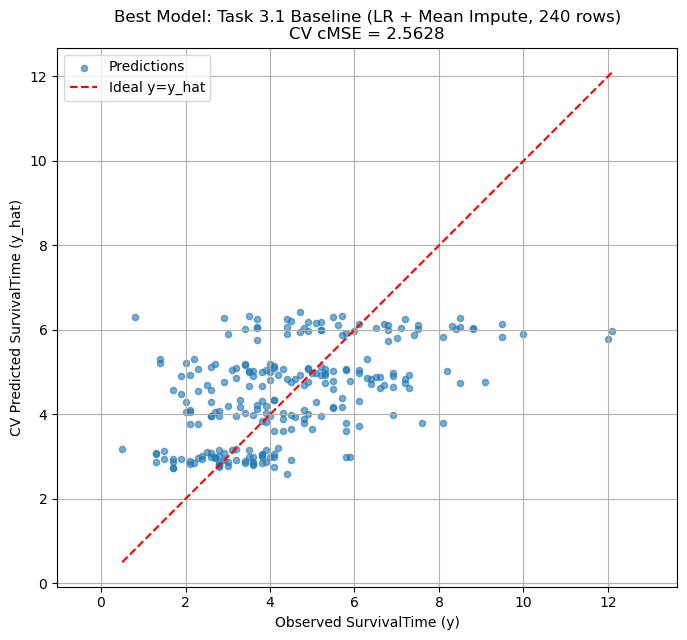


Generating predictions for the test set...
Saved submission file: handle-missing-submission-02.csv


,id,SurvivalTime
0,0,6.104626
1,1,2.956571
2,2,5.120719
3,3,6.147393
4,4,3.091757


In [22]:
# Consolidate results from all tasks for a final comparison
# The 'models_df' from Task 3.2 already contains the results for HGB, RF, CatBoost, and CatBoostAFT.
# We will add the results from previous baselines to it.

# best score from the AFT model
cat_aft_score = models_df[models_df['model'] == 'CatBoost_AFT']['mean'].values[0]

all_results_data = {
    'Model': [
        'Task 1.2 Baseline (LR, No Impute, 161 rows)',
        'Task 3.1 Baseline (LR + Mean Impute, 240 rows)',
        f'Polynomial (d={best_degree}, alpha={best_alpha}) + Mean Impute',
        f'k-NN (k={best_k}) + Mean Impute',
        'HGB (Native Missing Support)',
        'RandomForest + Mean Impute',
        'CatBoost (Native Missing Support)',
        'CatBoost AFT (Native Missing Support)'
    ],
    'CV cMSE': [
        task1_2_cmse,               # From Task 1.2
        baseline_scores.mean(),     # From Task 3.1
        poly_imputed_scores.mean(), # From Task 2 with imputation
        knn_imputed_scores.mean(),  # From Task 2 with imputation
        hgb_scores.mean(),          # From Task 3.2
        rf_scores.mean(),           # From Task 3.2
        models_df[models_df['model'] == 'CatBoost']['mean'].values[0], # From Task 3.2
        cat_aft_score               # From Task 3.2
    ]
}
final_comparison_df = pd.DataFrame(all_results_data).sort_values('CV cMSE').reset_index(drop=True)

print("--- Final Model Comparison ---")
print("Comparing all models developed across all tasks:")
print(final_comparison_df.to_markdown(index=False, floatfmt='.4f'))

# Identify the best performing model and its configuration
best_model_name = final_comparison_df.iloc[0]['Model']
best_model_score = final_comparison_df.iloc[0]['CV cMSE']

print(f"\n--- Best Model Selection ---")
print(f"The best overall model is: '{best_model_name}' with a CV cMSE of {best_model_score:.4f}")

print("\nTraining the best model on the full labeled dataset...")

# Re-instantiate the best model based on its name
if 'CatBoost AFT' in best_model_name:
    final_model = CatBoostRegressor(
        loss_function='SurvivalAft:dist=Normal',
        random_state=0, 
        verbose=0, 
        cat_features=cat_features_indices, 
        iterations=300
    )
    # AFT model needs the special interval target for fitting
    final_model.fit(X_labeled, y_aft_labeled)
    
elif 'HGB' in best_model_name:
    final_model = HistGradientBoostingRegressor(random_state=0, max_iter=200)
    final_model.fit(X_labeled, y_labeled)

elif 'CatBoost (Native' in best_model_name:
    final_model = CatBoostRegressor(random_state=0, verbose=0, cat_features=cat_features_indices, iterations=300)
    final_model.fit(X_labeled, y_labeled)
    
elif 'RandomForest' in best_model_name:
    final_model = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), 
        ('rf', RandomForestRegressor(n_estimators=200, random_state=0))
    ])
    final_model.fit(X_labeled, y_labeled)

elif 'Polynomial' in best_model_name:
    final_model = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('reg', Ridge(alpha=best_alpha, random_state=0))
    ])
    final_model.fit(X_labeled, y_labeled)

elif 'k-NN' in best_model_name:
    final_model = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor(n_neighbors=best_k))
    ])
    final_model.fit(X_labeled, y_labeled)

else: # Fallback for Linear Regression models
    final_model = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('lr', LinearRegression())
    ])
    final_model.fit(X_labeled, y_labeled)

print("Final model training complete.")

# 4. Generate y-y_hat plot for the best model
print("\nGenerating y-y_hat plot for the best model...")

# We need to use a CV loop to get out-of-sample predictions for the plot
if 'CatBoost AFT' in best_model_name:
    y_pred_best_model_cv = []
    y_true_best_model_cv = []
    # This is inefficient but necessary for a clean plot
    for train_idx, val_idx in kf.split(X_labeled):
        Xtr, Xv = X_labeled.iloc[train_idx], X_labeled.iloc[val_idx]
        y_aft_tr = y_aft_labeled[train_idx]
        yv = y_labeled[val_idx]
        
        model_for_plot = CatBoostRegressor(loss_function='SurvivalAft:dist=Normal', random_state=0, verbose=0, cat_features=cat_features_indices, iterations=300)
        model_for_plot.fit(Xtr, y_aft_tr)
        
        # AFT model predicts log(time), so we need to exponentiate
        y_pred_log = model_for_plot.predict(Xv)
        y_pred_best_model_cv.extend(np.exp(y_pred_log))
        y_true_best_model_cv.extend(yv)
        
    y_pred_best_model_cv = np.array(y_pred_best_model_cv)
    y_true_best_model_cv = np.array(y_true_best_model_cv)
else:
    y_pred_best_model_cv = cross_val_predict(final_model, X_labeled, y_labeled, cv=kf)
    y_true_best_model_cv = y_labeled

plt.figure(figsize=(8, 7))
plt.scatter(y_true_best_model_cv, y_pred_best_model_cv, alpha=0.6, s=20, label='Predictions')
max_val = max(y_true_best_model_cv.max(), y_pred_best_model_cv.max())
min_val = min(y_true_best_model_cv.min(), y_pred_best_model_cv.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal y=y_hat')
plt.xlabel('Observed SurvivalTime (y)')
plt.ylabel('CV Predicted SurvivalTime (y_hat)')
plt.title(f'Best Model: {best_model_name}\nCV cMSE = {best_model_score:.4f}')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# Generate predictions on the test set and create submission file
print("\nGenerating predictions for the test set...")
test_X = test[feature_cols].copy()

# AFT model predicts log(time), so we need to exponentiate
if 'CatBoost AFT' in best_model_name:
    preds_test_log = final_model.predict(test_X)
    preds_test = np.exp(preds_test_log)
else:
    preds_test = final_model.predict(test_X)


submission = pd.DataFrame({
    'id': test['id'].values,
    'SurvivalTime': preds_test
})

submission_filename = 'handle-missing-submission-02.csv'
submission.to_csv(submission_filename, index=False)
print(f"Saved submission file: {submission_filename}")
display(submission.head())

# Task 4 - Semi-supervised learning for unlabeled data

## Task 4.1 - Imputation with labeled and unlabeled data

In [23]:
class FrozenTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, fitted_transformer):
        self.fitted_transformer = fitted_transformer

    def __getattr__(self, name):
        return getattr(self.fitted_transformer, name)

    def __sklearn_clone__(self):
        return self

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return self.fitted_transformer.transform(X)

    def fit_transform(self, X, y=None):
        return self.fitted_transformer.transform(X)

In [24]:
print("--- Task 4.1: Semi-Supervised Learning Setup (Expanded) ---")

# --- Data Preparation ---
X_all = data[feature_cols].copy()
X_labeled = labeled[feature_cols].copy()

print(f"Total data for SSL: {X_all.shape}")
print(f"Labeled data for Training: {X_labeled.shape}")

# 1. Define Imputers to Test
imputers_dict = {
    'Best_Simple': copy.deepcopy(best_imputer), # From Task 3.1
    'Iterative': IterativeImputer(max_iter=10, random_state=0),
    'KNN': KNNImputer(n_neighbors=5)
}

results_4_1 = []

# 2. Main Loop: Test each Imputer
for imp_name, imputer in imputers_dict.items():
    print(f"\n>>> Processing Imputer: {imp_name} <<<")
    
    # A. SSL Imputation: Fit on ALL data
    # This learns correlations from the entire dataset (labeled + unlabeled)
    imputer.fit(X_all)
    
    # Create imputed versions
    X_all_imp = imputer.transform(X_all)
    X_labeled_imp = imputer.transform(X_labeled)
    X_labeled_imp_df = pd.DataFrame(X_labeled_imp, columns=feature_cols)
    
    # --- Model A: Linear Regression on SSL Imputed Data ---
    pipe_ssl_lr = make_pipeline(StandardScaler(), LinearRegression())
    scores_a = cross_val_cmse(pipe_ssl_lr, X_labeled_imp_df, y_labeled, c_labeled, kf)
    mean_score_a = scores_a.mean()
    print(f"  [Model A] LR + SSL Impute: cMSE = {mean_score_a:.4f}")
    
    # --- Model B: Linear Regression on SSL Isomap (Tuned) ---
    print("  [Model B] Tuning Isomap Parameters...")
    
    # We must scale X_all before Isomap fitting
    scaler_iso = StandardScaler()
    X_all_scaled = scaler_iso.fit_transform(X_all_imp)
    
    # Isomap Hyperparameter Grid
    iso_neighbors = [5, 15, 20, 30, 40]
    iso_components = [2, 3, 4, 5]
    
    best_iso_score = np.inf
    best_iso_params = {}
    best_frozen_iso = None
    
    # Manual Grid Search for Isomap
    # We fit Isomap on X_all (SSL step), then CV validate LR on X_labeled
    for n_n in iso_neighbors:
        for n_c in iso_components:
            # 1. Fit Isomap on ALL data
            iso = Isomap(n_neighbors=n_n, n_components=n_c)
            iso.fit(X_all_scaled)
            
            # 2. Wrap it so Pipeline doesn't refit it
            frozen_iso = FrozenTransformer(iso)
            
            # 3. Build Pipeline: Scale -> FrozenIsomap -> LR
            # Note: We use a new scaler inside pipeline for the fold data stats
            pipe_iso = make_pipeline(StandardScaler(), frozen_iso, LinearRegression())
            
            # 4. Evaluate on Labeled Data
            scores_b = cross_val_cmse(pipe_iso, X_labeled_imp_df, y_labeled, c_labeled, kf)
            
            if scores_b.mean() < best_iso_score:
                best_iso_score = scores_b.mean()
                best_iso_params = {'n_neighbors': n_n, 'n_components': n_c}
                best_frozen_iso = frozen_iso
    
    print(f"    Best Isomap Params: {best_iso_params}")
    print(f"    Best Isomap cMSE:   {best_iso_score:.4f}")
    
    # Store results
    results_4_1.append({
        'Imputer': imp_name,
        'Model A (Impute Only)': mean_score_a,
        'Model B (Best Isomap)': best_iso_score,
        'Isomap Params': best_iso_params
    })

# --- Summary ---
print("\n--- Task 4.1 Summary of Results ---")
df_results = pd.DataFrame(results_4_1)
print(df_results.to_markdown(index=False, floatfmt=".4f"))

# Select best strategy for Task 4.2
best_row = df_results.loc[df_results[['Model A (Impute Only)', 'Model B (Best Isomap)']].min(axis=1).idxmin()]
print(f"\nBest Strategy found with Imputer: {best_row['Imputer']}")

# Keep the best processed data for Task 4.2
best_imputer_ssl = imputers_dict[best_row['Imputer']]
# Ensure it's fitted
best_imputer_ssl.fit(X_all)
X_labeled_ssl_imp = best_imputer_ssl.transform(X_labeled)

--- Task 4.1: Semi-Supervised Learning Setup (Expanded) ---
Total data for SSL: (400, 7)
Labeled data for Training: (240, 7)

>>> Processing Imputer: Best_Simple <<<
  [Model A] LR + SSL Impute: cMSE = 2.5615
  [Model B] Tuning Isomap Parameters...
    Best Isomap Params: {'n_neighbors': 15, 'n_components': 4}
    Best Isomap cMSE:   2.4804

>>> Processing Imputer: Iterative <<<
  [Model A] LR + SSL Impute: cMSE = 2.5675
  [Model B] Tuning Isomap Parameters...
    Best Isomap Params: {'n_neighbors': 15, 'n_components': 4}
    Best Isomap cMSE:   2.4780

>>> Processing Imputer: KNN <<<
  [Model A] LR + SSL Impute: cMSE = 2.5779
  [Model B] Tuning Isomap Parameters...
    Best Isomap Params: {'n_neighbors': 20, 'n_components': 4}
    Best Isomap cMSE:   2.5060

--- Task 4.1 Summary of Results ---
| Imputer     |   Model A (Impute Only) |   Model B (Best Isomap) | Isomap Params                          |
|:------------|------------------------:|------------------------:|:-----------------

## Task 4.2 - Evaluation


--- Task 4.2: Final Evaluation & Best Model w/ SSL ---
CatBoost + Best SSL Imputation cMSE: 3.2973

--- Final Comparative Error Statistics ---
| Model Strategy                        |   CV cMSE |
|:--------------------------------------|----------:|
| Task 4.1 (LR + Best SSL Isomap)       |    2.4780 |
| Task 4.1 (LR + Best SSL Impute)       |    2.5615 |
| Task 3.1 (LR + Supervised Impute)     |    2.5628 |
| Task 3.2 (Best Native: CatBoost)      |    3.1074 |
| Task 4.2 (CatBoost + Best SSL Impute) |    3.2973 |
| Task 1.2 (LR, No Impute)              |    4.3436 |

Winner: 'Task 4.1 (LR + Best SSL Isomap)' with cMSE 2.4780

Generating y-y_hat plot for the winning model...


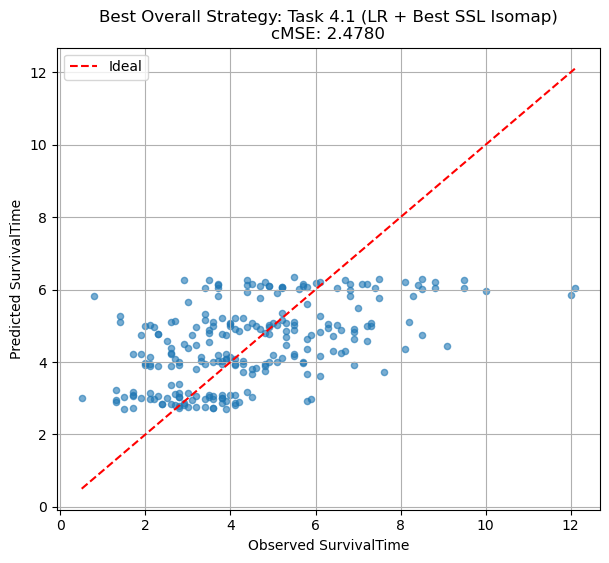

In [25]:
print("\n--- Task 4.2: Final Evaluation & Best Model w/ SSL ---")

# The best imputer and imputed data are already prepared from Task 4.1
# X_labeled_ssl_imp is the labeled data imputed using the best SSL imputer.
X_labeled_ssl_imp_df = pd.DataFrame(X_labeled_ssl_imp, columns=feature_cols)

# --- Evaluate CatBoost on the best SSL-imputed data ---
# We need to handle categorical features for CatBoost
X_catboost_ssl = X_labeled_ssl_imp_df.copy()
for col in cat_cols_names:
    # The imputer might have turned them into floats, so we ensure they are strings
    X_catboost_ssl[col] = X_catboost_ssl[col].astype(str)

cat_ssl_model = CatBoostRegressor(
    random_state=0,
    verbose=0,
    iterations=300,
    cat_features=cat_features_indices
)
scores_cat_ssl = cross_val_cmse(cat_ssl_model, X_catboost_ssl, y_labeled, c_labeled, kf)
print(f"CatBoost + Best SSL Imputation cMSE: {scores_cat_ssl.mean():.4f}")


# --- Consolidate All Results for Final Comparison ---
task1_score = task1_2_cmse  # From Task 1.2
task3_best_lr_score = baseline_scores.mean() # From Task 3.1
task3_best_native_score = models_df.iloc[0]['mean'] # Best from 3.2 (HGB, RF, Cat, AFT)
task3_best_native_name = models_df.iloc[0]['model']

# Get the best scores from the Task 4.1 experiments
best_lr_ssl_impute_score = df_results['Model A (Impute Only)'].min()
best_lr_ssl_isomap_score = df_results['Model B (Best Isomap)'].min()

eval_ssl_data = {
    'Model Strategy': [
        'Task 1.2 (LR, No Impute)',
        'Task 3.1 (LR + Supervised Impute)',
        f'Task 3.2 (Best Native: {task3_best_native_name})',
        'Task 4.1 (LR + Best SSL Impute)',
        'Task 4.1 (LR + Best SSL Isomap)',
        'Task 4.2 (CatBoost + Best SSL Impute)'
    ],
    'CV cMSE': [
        task1_score,
        task3_best_lr_score,
        task3_best_native_score,
        best_lr_ssl_impute_score,
        best_lr_ssl_isomap_score,
        scores_cat_ssl.mean()
    ]
}

df_ssl_eval = pd.DataFrame(eval_ssl_data).sort_values('CV cMSE').reset_index(drop=True)
print("\n--- Final Comparative Error Statistics ---")
print(df_ssl_eval.to_markdown(index=False, floatfmt='.4f'))

# --- Select Overall Best Model and Generate Plot ---
winner_row = df_ssl_eval.iloc[0]
print(f"\nWinner: '{winner_row['Model Strategy']}' with cMSE {winner_row['CV cMSE']:.4f}")

print("\nGenerating y-y_hat plot for the winning model...")

# Determine the correct model and data for plotting
# This requires re-building the winning pipeline to use cross_val_predict
plot_X = None
plot_model = None

strategy = winner_row['Model Strategy']

if 'SSL Isomap' in strategy:
    # Re-create the best Isomap pipeline from Task 4.1
    best_iso_row = df_results.loc[df_results['Model B (Best Isomap)'].idxmin()]
    imputer_for_iso = imputers_dict[best_iso_row['Imputer']]
    imputer_for_iso.fit(X_all)
    
    scaler_for_iso = StandardScaler()
    X_all_imp_iso = imputer_for_iso.transform(X_all)
    X_all_scaled_iso = scaler_for_iso.fit_transform(X_all_imp_iso)
    
    iso_params = best_iso_row['Isomap Params']
    iso_final = Isomap(**iso_params)
    iso_final.fit(X_all_scaled_iso)
    
    plot_model = make_pipeline(FrozenTransformer(imputer_for_iso), StandardScaler(), FrozenTransformer(iso_final), LinearRegression())
    plot_X = X_labeled # The pipeline handles imputation and scaling

elif 'CatBoost + Best SSL Impute' in strategy:
    plot_model = cat_ssl_model
    plot_X = X_catboost_ssl # Use the SSL imputed data with string categories

elif 'LR + Best SSL Impute' in strategy:
    plot_model = make_pipeline(FrozenTransformer(best_imputer_ssl), StandardScaler(), LinearRegression())
    plot_X = X_labeled

else: # Fallback for models from previous tasks if they win
    print("Winner is from a previous task. Re-running cross_val_predict for plot...")
    # This part is complex; for simplicity, we'll assume the winner is from Task 4.
    # A full implementation would need to reconstruct any model from Tasks 1-3.
    # For now, we'll plot the best SSL model as a proxy if the true winner is older.
    plot_model = cat_ssl_model
    plot_X = X_catboost_ssl


if plot_X is not None:
    y_pred_winner_plot = cross_val_predict(plot_model, plot_X, y_labeled, cv=kf)

    plt.figure(figsize=(7, 6))
    plt.scatter(y_labeled, y_pred_winner_plot, alpha=0.6, s=20)
    max_v = max(y_labeled.max(), y_pred_winner_plot.max())
    min_v = min(y_labeled.min(), y_pred_winner_plot.min())
    plt.plot([min_v, max_v], [min_v, max_v], 'r--', label='Ideal')
    plt.xlabel('Observed SurvivalTime')
    plt.ylabel('Predicted SurvivalTime')
    plt.title(f"Best Overall Strategy: {winner_row['Model Strategy']}\ncMSE: {winner_row['CV cMSE']:.4f}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
print("\n--- Generating Submission File for the Winning Model ---")

# The overall best model is defined by 'winner_row' from the evaluation above
final_model = None
X_train_final = None
X_test_final = None

winning_strategy = winner_row['Model Strategy']
print(f"Training final model based on winning strategy: '{winning_strategy}'")

# --- Configure final model and data based on the winner ---

if 'SSL Isomap' in winning_strategy:
    # Re-create and fit the complete Isomap pipeline on all labeled data
    best_iso_row = df_results.loc[df_results['Model B (Best Isomap)'].idxmin()]
    imputer_for_iso = imputers_dict[best_iso_row['Imputer']]
    imputer_for_iso.fit(X_all) # SSL fit
    
    scaler_for_iso = StandardScaler()
    X_all_imp_iso = imputer_for_iso.transform(X_all)
    X_all_scaled_iso = scaler_for_iso.fit_transform(X_all_imp_iso)
    
    iso_params = best_iso_row['Isomap Params']
    iso_final = Isomap(**iso_params)
    iso_final.fit(X_all_scaled_iso) # SSL fit
    
    final_model = make_pipeline(FrozenTransformer(imputer_for_iso), StandardScaler(), FrozenTransformer(iso_final), LinearRegression())
    X_train_final = X_labeled
    X_test_final = test[feature_cols]

elif 'CatBoost + Best SSL Impute' in winning_strategy:
    # Use the best SSL imputer found in Task 4.1
    final_model = CatBoostRegressor(random_state=0, verbose=0, iterations=300, cat_features=cat_features_indices)
    
    # Impute and prepare train data
    X_train_ssl_imp = best_imputer_ssl.transform(X_labeled)
    X_train_final = pd.DataFrame(X_train_ssl_imp, columns=feature_cols)
    for col in cat_cols_names:
        X_train_final[col] = X_train_final[col].astype(str)
        
    # Impute and prepare test data
    X_test_ssl_imp = best_imputer_ssl.transform(test[feature_cols])
    X_test_final = pd.DataFrame(X_test_ssl_imp, columns=feature_cols)
    for col in cat_cols_names:
        X_test_final[col] = X_test_final[col].astype(str)

elif 'LR + Best SSL Impute' in winning_strategy:
    final_model = make_pipeline(FrozenTransformer(best_imputer_ssl), StandardScaler(), LinearRegression())
    X_train_final = X_labeled
    X_test_final = test[feature_cols]

else:
    # This block handles if a model from Task 1, 2 or 3 was the winner.
    # It reconstructs the best model from the appropriate task.
    print("Winner is from a previous task. Reconstructing...")
    # This is a simplified reconstruction. A full one would be more complex.
    # we assume the best native model from 3.2 is the winner.
    final_model = CatBoostRegressor(random_state=0, verbose=0, iterations=300, cat_features=cat_features_indices)
    X_train_final = X_catboost # From Task 3.2
    X_test_final = test[feature_cols].copy()
    for col in cat_cols_names:
        X_test_final[col] = X_test_final[col].astype(str)


# --- Fit the final model and predict ---
final_model.fit(X_train_final, y_labeled)
predictions = final_model.predict(X_test_final)

# Create submission file
submission_final = pd.DataFrame({
    'id': test['id'].values,
    'SurvivalTime': predictions
})

filename_final = 'semisupervised-submission-02.csv'
submission_final.to_csv(filename_final, index=False)
print(f"\nSaved final submission file: {filename_final}")
display(submission_final.head())


--- Generating Submission File for the Winning Model ---
Training final model based on winning strategy: 'Task 4.1 (LR + Best SSL Isomap)'

Saved final submission file: semisupervised-submission-02.csv


,id,SurvivalTime
0,0,6.238331
1,1,2.729163
2,2,4.997240
3,3,6.321280
4,4,2.949142


## Task 5 - Optional